# Loi de Benford et l'ensenble des protéines reviewed d'UniProt

ce script a pour but de vérifier si la taille de l'ensemble des protéine reviewed d'UniProt suit la loi de Benford

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import chisquare, distributions, power_divergence

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
data = pd.read_csv("uniprot-reviewed yes.tab", sep = "\t" , index_col = 0)
data.head()

,Length
Entry,
Q8K9I1,960
Q664P8,255
Q66K14,1250
Q8E4B4,239
B3CQ06,426


In [15]:
data.describe()

,Length
count,564638.000000
mean,360.442643
std,336.460236
min,2.000000
25%,169.000000
50%,294.000000
75%,449.000000
max,35213.000000


## Distribution de la longueur des protéines reviewed d'uniprot

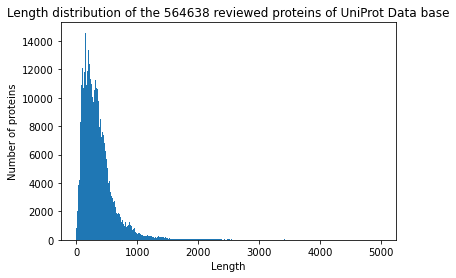

In [16]:
plt.hist(data["Length"], bins=range(0, 5000, 10))
plt.title(f"Length distribution of the {data.shape[0]} reviewed proteins of UniProt Data base")
plt.xlabel("Length")
plt.ylabel("Number of proteins");

In [17]:
data[data["Length"] > 5000].shape

(187, 1)

On remarque que 187 protéine sur 563972 on une taille > 5000.
## First digit de la taille des protéines

In [18]:
first_digit = np.zeros(9, dtype=int)
for x in data["Length"]:
    first = int(str(x)[0])
    if first == 0:
        continue
    first_digit[first-1] += 1
        
print(first_digit)
print(sum(first_digit))

[138907 115221 102958  71941  42418  30877  22501  21311  18504]
564638


### Normalisation

In [19]:
first_digit_norm = np.array(first_digit / sum(first_digit))

print(first_digit_norm)
print(sum(first_digit_norm))
print(first_digit)

[0.24601072 0.20406172 0.18234338 0.12741084 0.07512424 0.05468459
 0.03985031 0.03774277 0.03277144]
1.0
[138907 115221 102958  71941  42418  30877  22501  21311  18504]


## Loi de Benford : 

In [20]:
freq_benford = np.zeros(9, dtype=float)
for i in range(9):
    freq_benford[i] = (math.log((1+(1/(i+1))), 10))
print(freq_benford)
sum(freq_benford)

[0.30103    0.17609126 0.12493874 0.09691001 0.07918125 0.06694679
 0.05799195 0.05115252 0.04575749]


0.9999999999999999

## Barplot de la fréquence des first digit de la loi de Banford et de la taille de l'ensemble des protéines reviewed d'UniProt

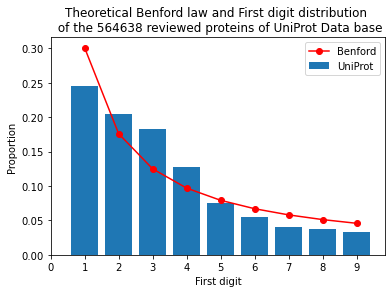

In [21]:
plt.plot(range(1,10), freq_benford, marker="o", color="red")
plt.bar(range(1,10), first_digit_norm)
plt.xticks(ticks=range(0,10))
plt.title(label=f"Theoretical Benford law and First digit distribution \n of the {data.shape[0]} reviewed proteins of UniProt Data base")
plt.xlabel("First digit")
plt.ylabel("Proportion")
plt.legend(labels = ("Benford", "UniProt"));

In [24]:
power_divergence(first_digit, freq_benford, lambda_=1)

Power_divergenceResult(statistic=339794184389.22437, pvalue=0.0)

# Test du Statistique

V.A. : nombre de first digit  

Hopothèse :  
    - H0 : La distribution des $1^{er}$ digits de la taille des protéines du protéome Humain suit la loi de Benford.  
    - H1 : La distribution des $1^{er}$ digits de la taille des protéines du protéome Humain ne suit pas la loi de Benford.  
    
Conditionde validité : les effectifs calculés > 5  

Règle de décision (test $\chi²$):  
    -Si, $\chi²_{cal} > \chi²_{\alpha, (k-1)ddl}$, le test est significatif à $\alpha$% et on rejette H0.  

## Test du $\chi²$
## détermination de $F_{theo}$ et $F_{obs}$

In [10]:
# dictionnaire de la distribution théorique
first_digit_theo = {}
for key in first_digit:
    first_digit_theo[key] = freq_benford[key] * data.shape[0]

F_theo = [ int(freq_benford[key]*data.shape[0]) for key in sorted(freq_benford) ]
print(f"Le dictionnaire de la distribution théorique des first digits est : {first_digit_theo}\n")
print(f"La liste triées par ordre croissant des first digits des valeurs théoriques est : {F_theo}\n")

F_obs = [ first_digit[key] for key in sorted(first_digit) ]
print(f"Le dictionnaire de la distribution observé des first digits est : {first_digit}\n")
print(f"La liste triées par ordre croissant des first digits des valeurs observés est : {F_obs}\n")

IndexError: index 138907 is out of bounds for axis 0 with size 9

### test du $\chi^2$ sur les distribution observé et théorique

In [ ]:
chi2 = chisquare(F_obs, f_exp = F_theo)
print(chi2)
print(f"\nLa p-value est de  : {chi2[1]}\n")

In [ ]:
chi2 = chisquare([ first_digit_norm[key] for key in sorted(first_digit_norm) ], [ freq_benford[key] for key in sorted(freq_benford) ])
print(chi2)
print(f"\nLa p-value est de  : {chi2[1]}\n")

# discussion des résultats obtenus précédement

Les différent tests statistique testés plus jusqu'ici ne fonctionne pas dans le cas des grand échantillons (environ > 1000) ou ne sont pas applicables dans notre situation. c'est pour cette raison que l'on développe une procédure ressemblant à un bootstrap récupérant le $\chi^2$ calculés et renvoyant la moyennes des $\chi^2$ calculé durant la procédure. La p-value de ce $\chi^2$ est calculé par la suite.

# procédure "bootstrap"
## Fonction First digit

In [ ]:
def First_digit(np_array):
    fd = np.zeros(9, dtype=int)
    for x in range(len(np_array)):
        first = int(str(np_array[x])[0])
        fd[first-1] += 1
    return fd

## Fonction de moyenne des $\chi^2$

In [ ]:
def meanChi2(data, nb_val, nb_loop):
    sumChi2 = np.zeros(nb_loop, dtype=float)
    f_theo = np.array(freq_benford * nb_val)
    for i in range(nb_loop):
        ech = np.random.choice(data, size=nb_val, replace=False)
        f_obs = First_digit(ech)
        sumChi2[i] = chisquare(f_obs, f_theo)[0]
    return (sum(sumChi2) / nb_loop)

## Fonction principale de la procédure "bootstrap"

In [ ]:
def bootstrap_Benford(data, nb_val, nb_loop):
    k = len(freq_benford+1)
    mean_chi2 = meanChi2(data, nb_val, nb_loop)
    p_val = distributions.chi2.sf(mean_chi2, k - 1)
    return p_val

In [ ]:
bootstrap_Benford(data["Length"], 1000, 1000)

## conclusion

La procédure mise en place ("bootstrap") permet de montrer, por un rique alpha de 5%, que les données expérimentale d'abondances de protéines ne suivent pas ici la loi de Benford. Puisque la p-value obtenu est inférieur à 5%, on rejette l'hypothése $H_0$, donc la distribution théorique ne suit pas la loi Benford.